## Clustering example

In [1]:
import pandas as pd
import numpy as np

Here we'll run some example of clustering using Samsung smartphone accelerometer data to classify some basic human activities. First we'll get the data from the Course's Dropbox folder. We'll use `rpy2` to read the .rda file format.

In [3]:
%load_ext rmagic

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


In [4]:
pip install rpy2

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached rpy2-3.4.4.tar.gz (187 kB)
    ERROR: Command errored out with exit status 1:
     command: /opt/conda/envs/Python-3.7-main/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/wsuser/pip-install-dnn1gkva/rpy2/setup.py'"'"'; __file__='"'"'/tmp/wsuser/pip-install-dnn1gkva/rpy2/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/wsuser/pip-pip-egg-info-1_2q2emj
     

In [2]:
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [9]:
%%R
download.file("https://dl.dropbox.com/u/7710864/courseraPublic/samsungData.rda",destfile="../data/samsungData.rda",method="curl")
load("../data/samsungData.rda")
write.csv(samsungData,file="../data/samsungData.csv")

UsageError: Cell magic `%%R` not found.


In [3]:
samsungData = pd.read_csv('../data/samsungData.csv')
samsungData = samsungData.drop(['Unnamed: 0'], axis=1)

A quick look on the column names and the type of activities in the data:

In [4]:
samsungData.columns[:12]

Index([tBodyAcc-mean()-X, tBodyAcc-mean()-Y, tBodyAcc-mean()-Z, tBodyAcc-std()-X, tBodyAcc-std()-Y, tBodyAcc-std()-Z, tBodyAcc-mad()-X, tBodyAcc-mad()-Y, tBodyAcc-mad()-Z, tBodyAcc-max()-X, tBodyAcc-max()-Y, tBodyAcc-max()-Z], dtype=object)

In [14]:
samsungData['activity'].value_counts()

laying      1407
standing    1374
sitting     1286
walk        1226
walkup      1073
walkdown     986

The scatter plots below show the first and second variable/feature vectors for subject number 1, colour coded by activity. We see that almost all activities have the first and second variable values around zero, except for LAYING, which is spread throughout the y-axis. 

The conclusion from these plots is that we can't really classify the activities based on the two variables, since their values are very close to each other.

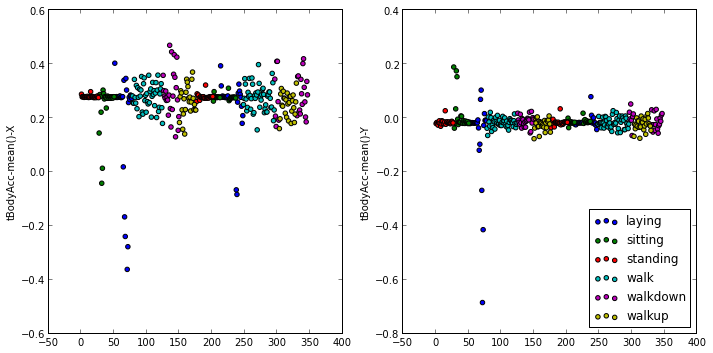

In [8]:
subj1 = samsungData[samsungData['subject'] == 1]

numericActivity = subj1.groupby('activity')

cols = {'laying' : 'b',
        'sitting' : 'g',
        'standing' : 'r',
        'walk' : 'c',
        'walkdown' : 'm',
        'walkup' : 'y'}

f, (ax1, ax2) = subplots(ncols=2)
f.set_size_inches(10, 5)

for act, df in numericActivity:
    ax1.scatter(df.index, df.ix[:,0], c=cols[act], label=act)
    ax2.scatter(df.index, df.ix[:,1], c=cols[act], label=act)

ax1.set_ylabel(samsungData.columns[0])
ax2.set_ylabel(samsungData.columns[1])
ax2.legend(loc='lower right')

f.tight_layout();

Let's run hierarchical clustering on the data, using the first three variables, which are:

In [10]:
subj1.ix[:,:3].columns

Index([tBodyAcc-mean()-X, tBodyAcc-mean()-Y, tBodyAcc-mean()-Z], dtype=object)

The dendrogram below again shows that there is no 'clustering' of the activities based on the used variables.

I use the character 'O' repeated n times to encode the activities in the x-axis of the dendrogram, where n goes from 1 to 6. That is 'O' represents LAYING, and 'OOOOOO' represents WALKUP.

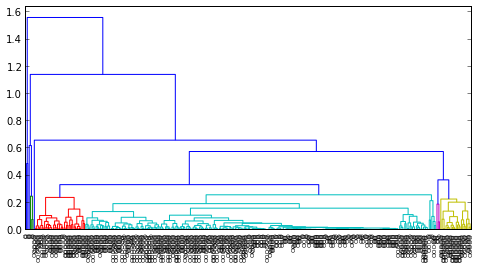

In [17]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

actlabels = pd.Categorical.from_array(subj1['activity'])

distanceMatrix = pdist(subj1.ix[:,:3])
dendrogram(linkage(distanceMatrix, method='complete'), 
           color_threshold=0.3, 
           leaf_label_func=lambda x: 'O' * (actlabels.labels[x] + 1),
           leaf_font_size=6)

f = gcf()
f.set_size_inches(8, 4);

Let's see if variable number 9 and 10 could give us a better clustering. These are:

In [20]:
subj1.ix[:,[9, 10]].columns

Index([tBodyAcc-max()-X, tBodyAcc-max()-Y], dtype=object)

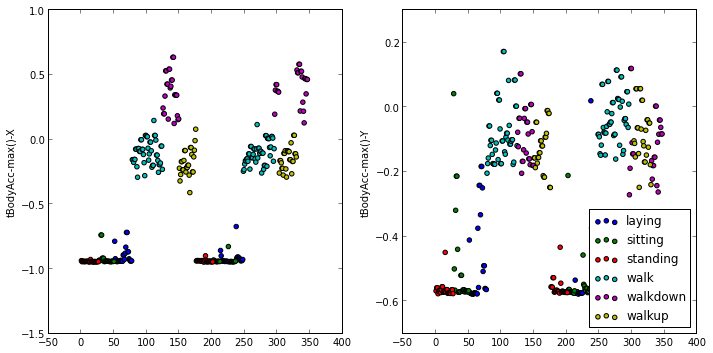

In [22]:
f, (ax1, ax2) = subplots(ncols=2)
f.set_size_inches(10, 5)

for act, df in numericActivity:
    ax1.scatter(df.index, df.ix[:,9], c=cols[act], label=act)
    ax2.scatter(df.index, df.ix[:,10], c=cols[act], label=act)

ax1.set_ylabel(samsungData.columns[9])
ax2.set_ylabel(samsungData.columns[10])
ax2.legend(loc='lower right')

f.tight_layout();

As we can see `tBodyAcc-max()-X` values show some grouping for WALK, WALKUP, and WALKDOWN. In particular, the variable values for activity WALKDOWN is very well separated from the others. We still can't separate WALK from WALKUP. The same also for `tBodyAcc-max()-Y`.

If we look at the dendrogram, taking variables number 9 to 12, we have the same conclusion as just mentioned, namely that WALKDOWN is very well separated from the others (those are labeled with 5 'O's in the horizontal axis). Yet we still can't see any groupings for other activities.

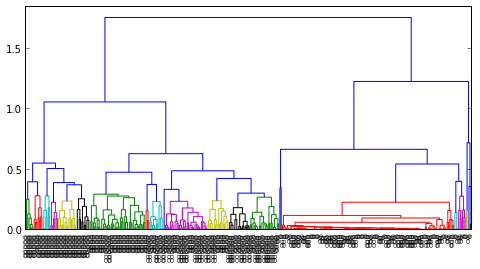

In [23]:
distanceMatrix = pdist(subj1.ix[:,9:12])
dendrogram(linkage(distanceMatrix, method='complete'), 
           color_threshold=0.3, 
           leaf_label_func=lambda x: 'O' * (actlabels.labels[x] + 1),
           leaf_font_size=6)

f = gcf()
f.set_size_inches(8, 4);

Now we'll use SVD to figure out which variables have the most importance, i.e. the ones that best separate the activities. To do this we need to normalize the matrix that contains all variable values for all observations, excluding the subject ID and the activity value. 

Such scaling functionality is actually available in `scikit-learn`, but since it's just a simple scaling that we need, we'll just define a short function to do that:

In [24]:
# a simple scale function to normalize a matrix
def scale(matrix):
    from numpy import mean, std
    return (matrix - mean(matrix, axis=0)) / std(matrix, axis=0)

In [25]:
U, D, Vt = np.linalg.svd(subj1.ix[:,:-2].apply(scale), full_matrices=False)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/frame.py:3576: FutureWarning: rename with inplace=True  will return None from pandas 0.11 onward
  " from pandas 0.11 onward", FutureWarning)


If we make scatter plots of the first and the second columns of the U matrix, grouped by activities, we'll see that WALKUP is very well separated from other activities:

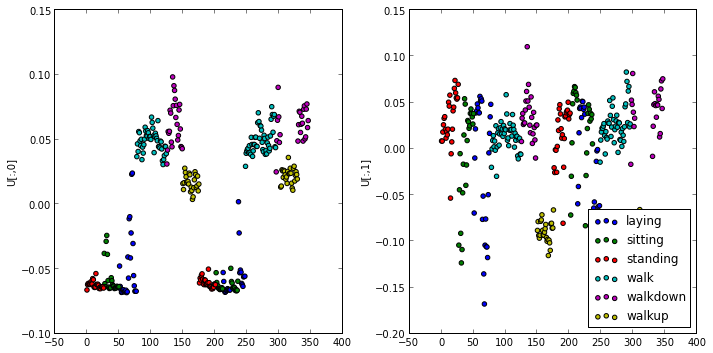

In [26]:
f, (ax1, ax2) = subplots(ncols=2)
f.set_size_inches(10, 5)

for lb, cl in zip(list(actlabels.levels), 'b g r c m y k'.split()):
    idx = subj1['activity'] == lb
    ax1.scatter(subj1.index[idx], U[idx,0], c=cl, label=lb)
    ax2.scatter(subj1.index[idx], U[idx,1], c=cl, label=lb)
    
ax1.set_ylabel('U[:,0]')
ax2.set_ylabel('U[:,1]')
ax2.legend(loc='lower right')

f.tight_layout();

Now what we can also do, is to look for which variable that contributes most significantly for this separation. To do this, we'll look at the Vt matrix. The following steps will plot the first-row values of the Vt matrix, and get the location/index of the maximum value. This index corresponds to the variable number that best separates the WALKUP activity.

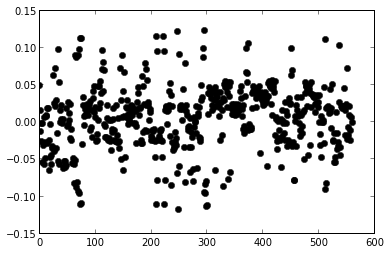

In [27]:
plot(Vt[1,:], 'ok');

In [31]:
maxContrib = np.argmax(Vt[1,:])
maxContrib

295

If we now include this variable (i.e. number 295) hopefully we can add the separation of WALKUP to our previously obtained separation of WALKDOWN. To see it we'll compute another hierarchical cluster and plot its dendrogram:

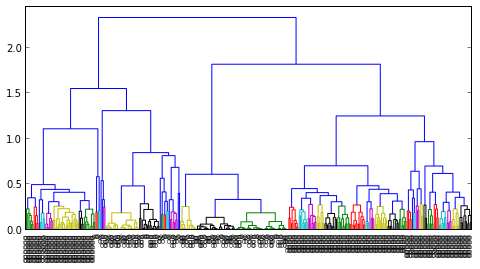

In [34]:
distanceMatrix = pdist(subj1.take(range(9,12) + [maxContrib], axis=1))
dendrogram(linkage(distanceMatrix, method='complete'), 
           color_threshold=0.3, 
           leaf_label_func=lambda x: 'O' * (actlabels.labels[x] + 1),
           leaf_font_size=6)

f = gcf()
f.set_size_inches(8, 4);

And it works! We can see now that WALKDOWN (with 6 'O's on the left hand side of the horizontal axis) is completely separated from WALK (4 'O's) and WALKUP (5 'O's). 

Since we are curious, let's check out what variable it is that separates WALKDOWN from everything else, the one that we discovered through SVD:

In [36]:
samsungData.columns[maxContrib]

'fBodyAcc-meanFreq()-Z'

It's got something to do with the Z-axis, which kind a make sense, sort of.

<br><b>K-means</b>

Another approach is to use K-means clustering. Here we'll just 'throw out' the feature/variable matrix to the K-means algorithm implementation from `scipy`, knowing that we have 6 cluster centres (i.e. 6 activities). Then we'll show in tabular form which activity is classified in which cluster.

In [37]:
from scipy.cluster.vq import kmeans, vq

data = np.matrix(subj1.ix[:,:-2])

centers, _ = kmeans(data, 6, iter=100)
cluster, _ = vq(data, centers)

df = pd.crosstab(cluster, subj1['activity'])
df

activity  laying  sitting  standing  walk  walkdown  walkup
row_0                                                      
0              0        0         0     0        48       0
1              4        0         0     0         0      53
2              0        0         0    95         1       0
3             27        0         0     0         0       0
4             19       13         3     0         0       0
5              0       34        50     0         0       0

To read the table, we look at the columns, which show the 'True' activities, and go down through the rows to see in which cluster centre(s) the activity is assigned by the K-means algorithm. We can see that WALK, WALKDOWN, and WALKUP are classified almost exclusively to one cluster. We don't see so many classification errors for STANDING as well. SITTING and LAYING, on the other hand, are not so easy to cluster. As we see there are quite some misclassifications for these activities.



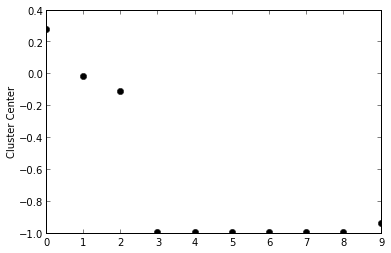

In [44]:
idmax = np.argmax(df['laying'])

plot(centers[idmax,:10], 'ok')
ylabel('Cluster Center');

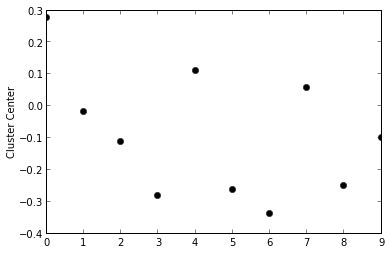

In [47]:
idmax = np.argmax(df['walk'])

plot(centers[idmax,:10], 'ok')
ylabel('Cluster Center');